#### ДЗ_28  - распознавание возраста
#### Татур А.А.
##### 26.02.2023
##### v.0.3 Взята модель из версии 0.2 и Дообучена за сче добавления случайных аугментации к тренировочному набору в функции ImageDataGenerator. Процесс генерации и дообучения повторен несколько раз. /// Процесс обучения первоначальной модели и ее структуру см.в версии 0.2///

##### Задача: используя данный датасет провести его очистку и обучения модели, которая бы определяла возраст по фотографии (Задача регрессии)
##### Датасет: https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar + https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar

##### Результат: добавление аугментаций увеличило MAE на 0.29 до 7.32

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, CategoryEncoding, AveragePooling2D,\
                                    Dropout, BatchNormalization, AveragePooling2D, GlobalMaxPool2D
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import RootMeanSquaredError
import tensorflow as tf

pd.set_option('display.max_rows', 30)

In [2]:
#### Функция для построения графика обучения на тренировочном и обучающем наборе:
def test_val_graph (history,train,val):
    plt.plot(history.history[train], label='Точность на обучающем наборе')
    plt.plot(history.history[val], label='Точность на проверочном наборе')
    plt.xlabel('Цикл обучения')
    plt.ylabel('Точность')
    plt.legend()
    plt.show()
    pass;

#### 01. Загружаем файлы. Формируем датайфрейм ссылка/возраст для фалов с лицами. Сохраняем в .csv файл

In [15]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
df = pd.DataFrame(columns=['link', 'age']) ### Создаем пустой Dataframe с колонками Link - ссылка на файл, Age - Возраст

for folder_name in os.listdir ('D:\\data'):
    for file_name in tqdm(os.listdir('D:\\data\\'+folder_name)):
        #формируем ссылку на изображение
        link = 'D:\\data\\' + folder_name + '\\' + file_name
        
        #### Распознавание лица с помощью каскадов Хаара
        
        img = cv2.imread(link)
        if img.shape[0]<96: ### Уберем совсем мелкие и неинформативные изображения
            continue
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade. ## Выставим досточно жесткие условия.
        
        #### Если лицо обнаружено (сумма элементов массива больше 0), то добавляем строку в Dataframe
        if len(faces)>0:
            if len(faces)>1: ### Уберем изображения, на которых выявлено несколько лиц.
                continue
            #определяем возраст
            name = file_name[:-4] #убираем расширение файла из имени
            age_end = name.split('_')[-1] # делаем сплит по нижнему подчеркиванию и выбираем последнюю дату
            age_start=str(name.split('_')[-2]).split('-')[0] # делаем сплит, выбираем первую дату и далаем сплит по дефису, 
                                                            # выбираем год.
            age_fin = int(age_end)-int(age_start) #Вычисляем возраст
            
            if age_fin>100 or age_fin<0: # Если возраст больше 100 или меньше 0, то выкидываем из набора
                continue
            
            #формируем временный датафрейм
            data = pd.DataFrame({"link": [link],
                                 "age": [age_fin]})
            #Делаем конкатенацию с основным датафреймом.
            df = pd.concat([df,data])

df.to_csv('data_cleaned_full.csv') #Сохраним в файл полученный Dataframe на случай перезагрузки, чтобы не чистить второй раз )))

100%|██████████| 4856/4856 [01:30<00:00, 53.82it/s]


In [16]:
df

,link,age
0,D:\data\00\10049200_1891-09-16_1958.jpg,67
0,D:\data\00\10110600_1985-09-17_2012.jpg,27
0,D:\data\00\10126400_1964-07-07_2010.jpg,46
0,D:\data\00\1013900_1917-10-15_1960.jpg,43
0,D:\data\00\10166400_1960-03-12_2008.jpg,48
...,...,...
0,D:\data\99\nm3361199_rm775597568_1990-3-26_201...,21
0,D:\data\99\nm3361199_rm993701376_1990-3-26_201...,21
0,D:\data\99\nm3724099_rm129678592_1997-7-5_2010...,13
0,D:\data\99\nm3724099_rm2764539648_1997-7-5_201...,13


#### 01.1. Очистим полученный сет. Выделим из изображений только картинки и уберем все входные с рашисрением меньше 150

In [17]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
df_croped = pd.DataFrame(columns=['link', 'age']) ### Создаем пустой Dataframe с колонками Link - ссылка на файл, Age - Возраст

for index in tqdm(range(len(df))): #
    link = df.iloc[index]['link']
    age = df.iloc[index]['age']
    f_name = df.iloc[index]['link'].split('\\')[-1]
    new_link = 'D:\\croped\\' + f_name #### Определяем новый путь для сохранения обрезанного файла
    
    img = cv2.imread(link)
    
    if img.shape[0]<150: #уберем совсем мелкие изображения, где распознать лицо затруднительно.
        continue
    
    if img.shape[-1]==3:
        img_new = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        img_new = img
    
    faces = face_cascade.detectMultiScale(img_new, 
                                          1.05, 
                                          2)
    
    if len(faces)>0: ### Выберем только то, где найдены лица.
        
        if len(faces)>1: ### Если выявлены множественные лица - пропуск
            continue
            
        x, y, w, h = faces[0]
        face_selected = img[y:y+h, x:x+h] ### Выделим лица
        cv2.imwrite(new_link,             ### Сохраним в файл с таким же именем, но в новую папку.
                    face_selected)
        
        data = pd.DataFrame({"link": [new_link],
                             "age": [age]})
        
        df_croped = pd.concat([df_croped,data])
        
df_croped.to_csv('data_croped_full.csv') ##### сохраняем новый DataFrame c обновленными путями в файл

100%|██████████| 251494/251494 [3:08:46<00:00, 22.20it/s]  


#### 01.2. Загрузим полученный датасет

In [3]:
df = pd.read_csv ('data_croped_full.csv')

In [16]:
df

,Unnamed: 0,link,age
0,0,D:\croped\10049200_1891-09-16_1958.jpg,67
1,0,D:\croped\10110600_1985-09-17_2012.jpg,27
2,0,D:\croped\1013900_1917-10-15_1960.jpg,43
3,0,D:\croped\10166400_1960-03-12_2008.jpg,48
4,0,D:\croped\10525500_1916-02-14_1951.jpg,35
...,...,...,...
132495,0,D:\croped\nm3361199_rm775597568_1990-3-26_2011...,21
132496,0,D:\croped\nm3361199_rm993701376_1990-3-26_2011...,21
132497,0,D:\croped\nm3724099_rm129678592_1997-7-5_2010.jpg,13
132498,0,D:\croped\nm3724099_rm2764539648_1997-7-5_2010...,13


#### Выведем рандомные 25 изображений из полученного списка

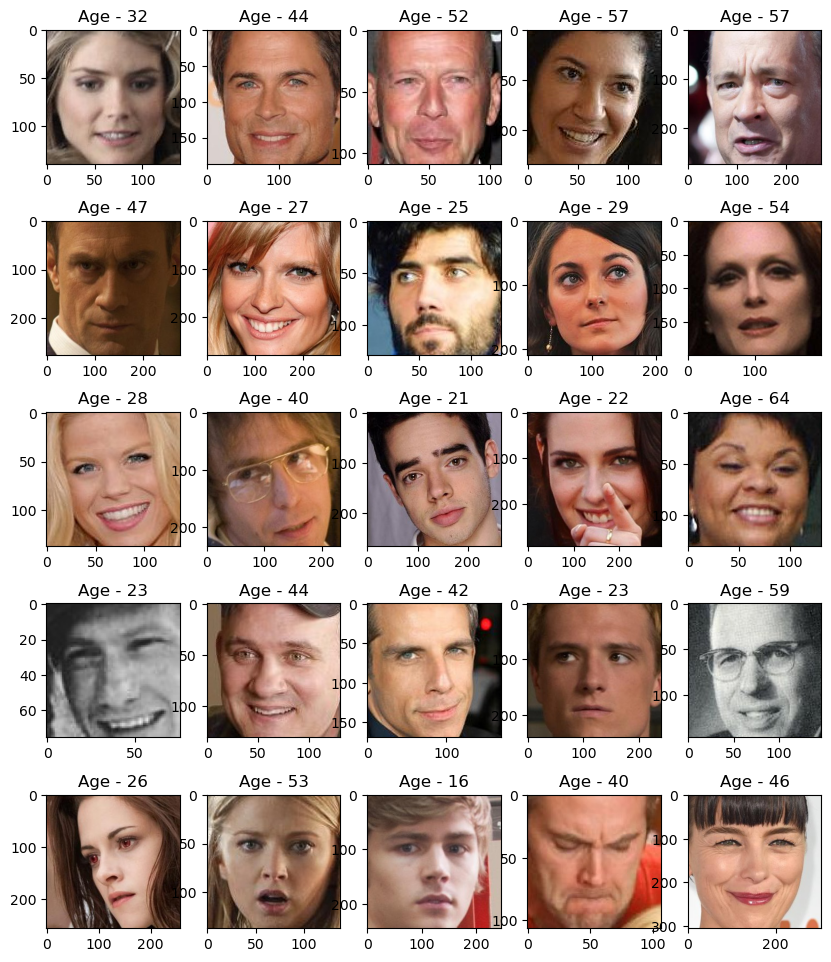

In [5]:
idx = np.random.randint (0,len(df),25)
plt.figure(figsize=(10,12))
for idx in enumerate(idx):
    plt.subplot (5,5,idx[0]+1)
    link = df.iloc[idx[1]]
    image = plt.imread(link[1])
    title = 'Age - ' + str(link[2])
    plt.title (title)
    plt.imshow(image, cmap='gray');

#### 02. Загружаем сет. Формируем тренировочный и тестовый набор

In [19]:
train, test = train_test_split(df, test_size=0.2, random_state=34)
model_conv = load_model ('ConvModelFull.h5') ##### Загрузим модель из версии 0.2
checkpoint_cb_conv = ModelCheckpoint("ConvModelFullAug.h5", 
                                     monitor = 'val_mae',
                                     save_best_only=True)

lr_scheduler = ReduceLROnPlateau(factor=0.2, patience=2)
TARGET_SIZE = (112,112)

#### 03. Создаем генератор

In [20]:
train_datagen=ImageDataGenerator(rescale=1./255.,
                                 validation_split=0.3,
                                 rotation_range=15, #### Коэффициент для рандомного поворота 
                                 width_shift_range=0.35, #### Коэффициент для шифта по ширине
                                 height_shift_range=0.25, #### Коэффициент для шифта по высоте
                                 horizontal_flip=True)

test_datagen=ImageDataGenerator(rescale=1./255.)

#### 04. Создадим цикл в котором будут применяться случайные аугментации к трейновому набору и проводиться дообучение модели, полученной в версии 0.2 (обучена на изображениях без аугментаций)

Found 74200 validated image filenames.
Found 31800 validated image filenames.
Epoch 1/10
2319/2319 [==============================] - 417s 179ms/step - loss: 103.4512 - mae: 7.5407 - val_loss: 108.1061 - val_mae: 7.6914 - lr: 2.0000e-06
Epoch 2/10
2319/2319 [==============================] - 413s 178ms/step - loss: 103.1737 - mae: 7.5297 - val_loss: 107.3755 - val_mae: 7.6637 - lr: 2.0000e-06
Epoch 3/10
2319/2319 [==============================] - 428s 184ms/step - loss: 102.4913 - mae: 7.4953 - val_loss: 106.9568 - val_mae: 7.6212 - lr: 2.0000e-06
Epoch 4/10
2319/2319 [==============================] - 437s 188ms/step - loss: 102.2729 - mae: 7.4912 - val_loss: 107.1939 - val_mae: 7.6020 - lr: 2.0000e-06
Epoch 5/10
2319/2319 [==============================] - 447s 193ms/step - loss: 101.9264 - mae: 7.4824 - val_loss: 106.2619 - val_mae: 7.5961 - lr: 2.0000e-06
Epoch 6/10
2319/2319 [==============================] - 433s 186ms/step - loss: 101.7927 - mae: 7.4675 - val_loss: 106.4618 - v

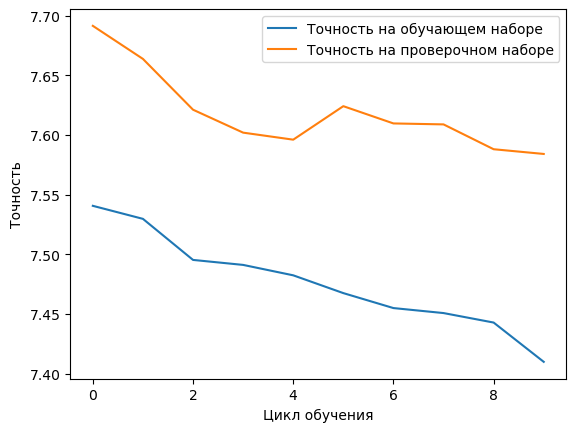

Found 74200 validated image filenames.
Found 31800 validated image filenames.
Epoch 1/10
2319/2319 [==============================] - 442s 190ms/step - loss: 100.8469 - mae: 7.4286 - val_loss: 106.1000 - val_mae: 7.5936 - lr: 4.0000e-07
Epoch 2/10
2319/2319 [==============================] - 442s 190ms/step - loss: 100.7199 - mae: 7.4259 - val_loss: 105.8380 - val_mae: 7.5767 - lr: 4.0000e-07
Epoch 3/10
2319/2319 [==============================] - 450s 194ms/step - loss: 100.6693 - mae: 7.4262 - val_loss: 105.8415 - val_mae: 7.5623 - lr: 4.0000e-07
Epoch 4/10
2319/2319 [==============================] - 433s 187ms/step - loss: 100.7416 - mae: 7.4225 - val_loss: 106.0179 - val_mae: 7.5696 - lr: 4.0000e-07
Epoch 5/10
2319/2319 [==============================] - 427s 184ms/step - loss: 100.5387 - mae: 7.4130 - val_loss: 105.5977 - val_mae: 7.5615 - lr: 8.0000e-08
Epoch 6/10
2319/2319 [==============================] - 459s 198ms/step - loss: 100.4931 - mae: 7.4083 - val_loss: 105.8717 - v

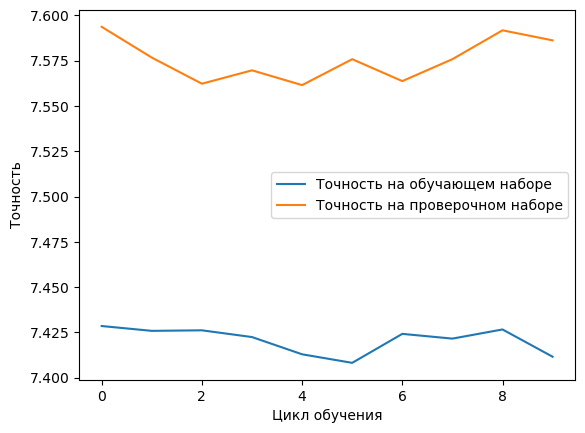

In [21]:
for i in range (2):
    
    ##### Создадим новый набор с рандомными аугментациями.
    
    train_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="./",
    x_col="link",
    y_col="age",
    subset="training",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="raw",
    color_mode='rgb',
    target_size=TARGET_SIZE)

    valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="./",
    x_col="link",
    y_col="age",
    subset="validation",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="raw",
    color_mode='rgb',
    target_size=TARGET_SIZE)
    
    #### Дообучим модель
    
    history2 = model_conv.fit(train_generator,
                          validation_data=valid_generator,
                          callbacks=[checkpoint_cb_conv,lr_scheduler],
                          epochs=10)
    
    test_val_graph (history2,'mae','val_mae')

#### 05. Сгенерирум тестовый набор и оценим модель.

In [24]:
test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory="./",
x_col="link",
y_col="age",
batch_size=32,
seed=42,
shuffle=False,
class_mode="raw",
color_mode='rgb',
target_size=TARGET_SIZE)

Found 26500 validated image filenames.


In [30]:
model_conv.evaluate (test_generator) #7.6163

829/829 [==============================] - 137s 165ms/step - loss: 99.6920 - mae: 7.3240


[99.69200134277344, 7.324040412902832]

#### 06. Пробуем построить предсказание по фотографиям c помощью собственной сети.

In [31]:
model_conv = load_model ('ConvModelFullAug.h5')

1/1 [==============================] - 0s 30ms/step


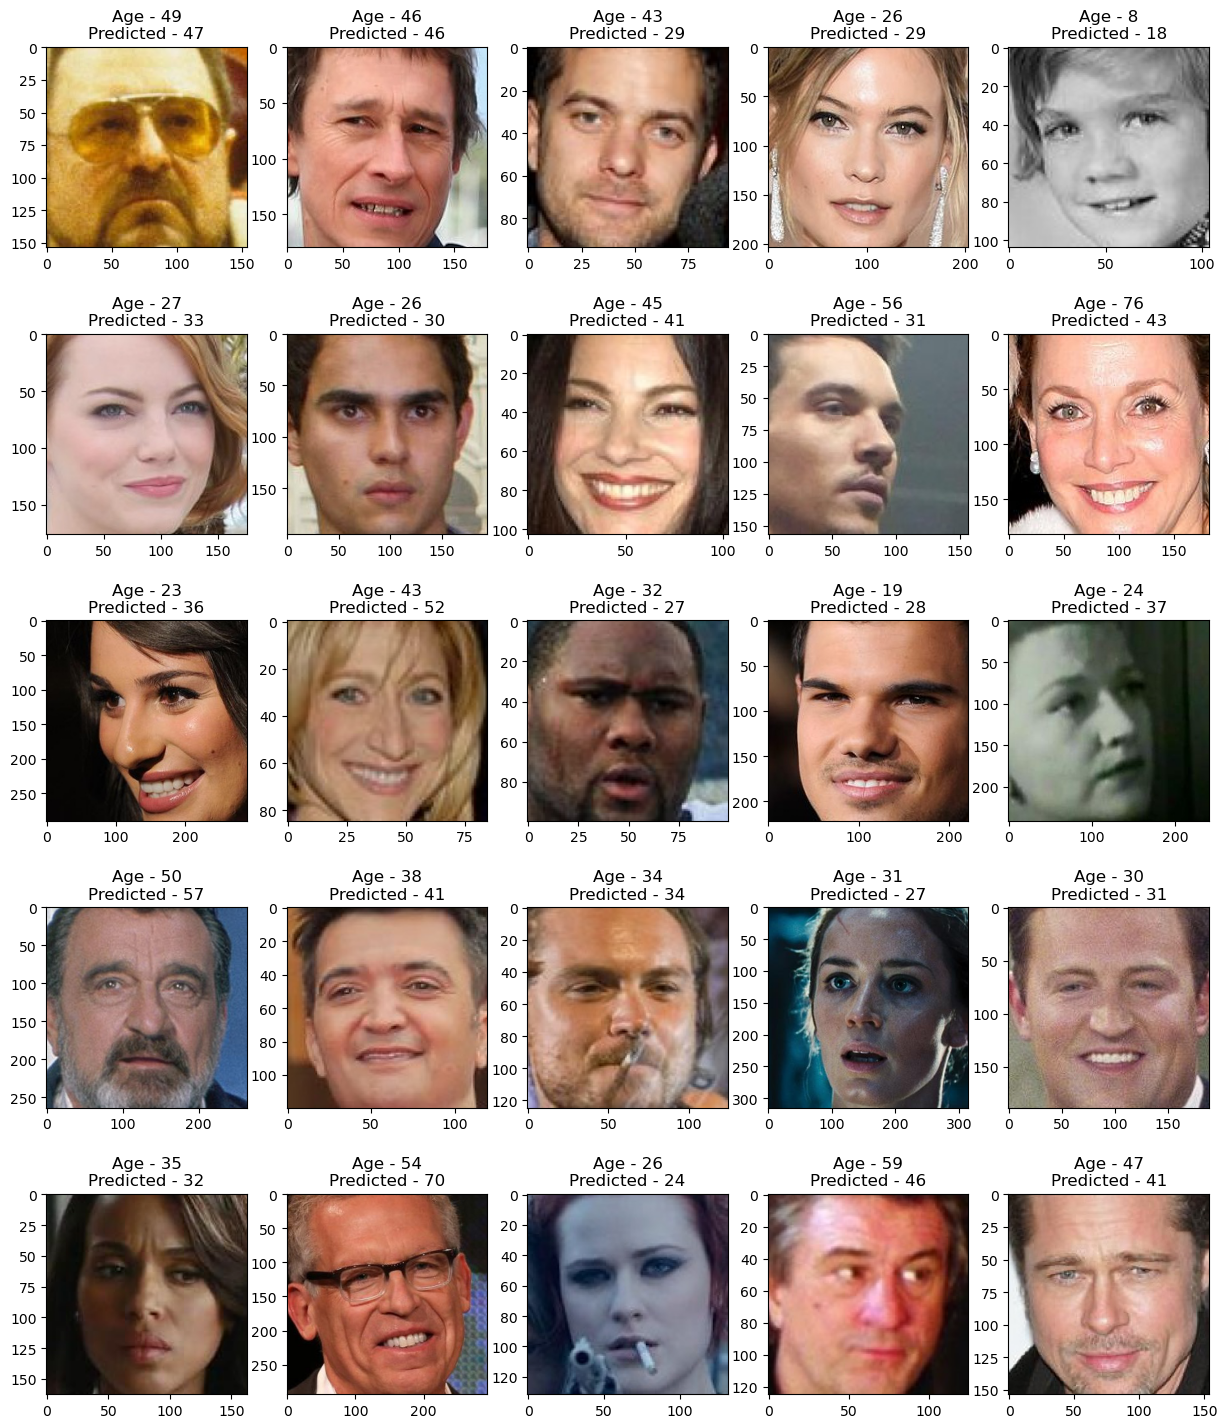

In [33]:
idx = np.random.randint (0,len(test),25)
plt.figure(figsize=(15,18))
for idx in enumerate(idx):
    plt.subplot (5,5,idx[0]+1)
    link = test.iloc[idx[1]]
    image = plt.imread(link[1])
    
    #if image.shape[-1]==3:
    #    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #else:
    #    gray=image
    
    img_resized = cv2.resize (image, (112,112))/255 #,
    img_reshaped  = img_resized.reshape (1,112,112,3)
    predict = model_conv.predict(img_reshaped)[0][0];
    
    title = 'Age - ' + str(link[2]) + '\nPredicted - ' + str(int(predict))
    plt.title (title)
    plt.imshow(image, cmap='gray');

#### 07. Пробуем предсказать по изображению с видеокамеры

In [34]:
cap = cv2.VideoCapture(0)
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
x=0
model = load_model('ConvModelFullAug.h5')
predict_avg = []
age=None

while True:
    ret, frame = cap.read()

    if x%5==0: ##### Показываем каждый пятый кадр для ускорения работы.
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray,
                                              scaleFactor=1.1,
                                              minNeighbors=6)
        
        for x,y,w,h in faces:
            
            cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,255),2)
            img = frame[x:x+w,y:y+h]
            
            img_resized = cv2.resize (img, (112,112))/255 #,
            img_reshaped  = img_resized.reshape (1,112,112,3)
            predict = model.predict(img_reshaped, verbose=0)[0][0];
            
            predict_avg.append(predict)
            
            if x%10==0: #### Возраст опредеделяется как среднее всех значений на каждую 10-ю итерацию
                age = int(sum(predict_avg)/len(predict_avg))
            
            cv2.putText(frame, 
                            'Age - ' + str(age), 
                            (x, y+h+25), 
                            cv2.FONT_HERSHEY_DUPLEX, 
                            1, 
                            (0, 0, 255), 
                             2)
            
            
            cv2.imshow('frame', frame)   
            
    x+=1
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

##### Скриншот кадра

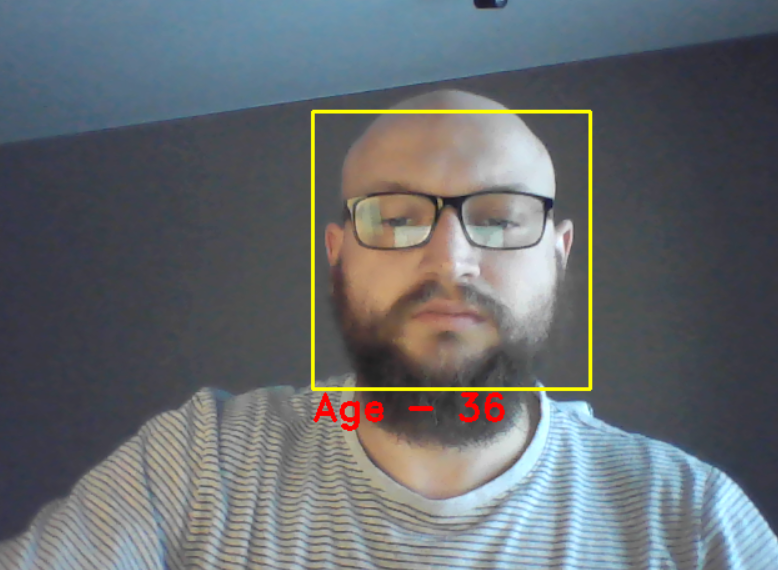